# Predicting Systolic and Diastolic Blood Pressure based on photopletysmography(PPG) signal

In this project I will compare how different machine learing approaches can be used to predict SBP and DPB based on the PPG signal, discuss their advantages and shortcomings and export the models for further usage. The data will be first read, explored and cleaned. Then, relevant features will be extracted and the the models will be constructed. The models will be then trained and validated to assess their performance. Finally, some fine tuning will be done, in order to minimize the loss functions and achieve best results.

## Data reading and processing

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
%cd /content/gdrive/MyDrive/Colab\ Notebooks/BloodPressure

/content/gdrive/MyDrive/Colab Notebooks/BloodPressure


In [ ]:
!git add .

In [16]:
!git commit -m "Better accuracy with longer segments."

[master (root-commit) d61994a] Add basic ML approach. Signal part of the features.
 1 file changed, 1 insertion(+)
 create mode 100644 BloodPressurePPG.ipynb


In [20]:
!git push origin master

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 346.74 KiB | 9.91 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0)
To https://github.com/JDuchniewicz/BloodPressurePPG
 * [new branch]      master -> master


In [22]:
!pip install mat73

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mat73
import os
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt

# feature extraction
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn import tree

# pytorch

In [18]:
DATA_FOLDER = "./data"

In [25]:
# download and load the data

chunk_size = 4096
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00340/data.zip"
req = requests.get(url, stream = True)
total_size = int(req.headers['content-length'])
 
with open("data.zip", "wb") as file:
    for data in tqdm(iterable=req.iter_content(chunk_size=chunk_size), total = total_size/chunk_size, unit='KB'):
        file.write(data)

100%|█████████▉| 819823/821084.8815917969 [00:46<00:00, 16910.17KB/s]/usr/local/lib/python3.6/dist-packages/tqdm/std.py:484: TqdmWarning: clamping frac to range [0, 1]
  charset=Bar.ASCII if ascii is True else ascii or Bar.UTF)
100%|██████████| 821085/821084.8815917969 [00:46<00:00, 17646.03KB/s]


In [26]:
# extract the data
if not os.path.exists(DATA_FOLDER):
    os.mkdir(DATA_FOLDER)
        
import zipfile
with zipfile.ZipFile("data.zip", "r") as ref:
    ref.extractall(DATA_FOLDER)

In [19]:
os.listdir(DATA_FOLDER)

['Part_1.mat', '__MACOSX', 'Part_2.mat', 'Part_3.mat', 'Part_4.mat']

In [20]:
# load the data from matlab matrix format to pandas dataframes
test_samples = mat73.loadmat(f"{DATA_FOLDER}/Part_1.mat")['Part_1'] # coalesce all matrices into one?

## SBP and DBP preparation

In [ ]:
len(test_samples)

3000

The three signals are:
   - PPG - Photopletysmography
   - ABP - Arterial Bloop Pressure
   - ECG - Electrocardiograph

In [ ]:
# number of entries in each sample
len(test_samples[0])

3

In [ ]:
# number of readings of each type
len(test_samples[0][0])

61000

In [21]:
# the sampling speed - 125 Hz
FS = 125

In [22]:
# SAMPLE_SIZE = 125 # the frequency in Hz (1 second samples)
# segments of 10 seconds
SAMPLE_SIZE = 1250
NUM_PERIODS = SAMPLE_SIZE // FS
# partition the data into equal length pgg segments
ppg = []
for i in range(len(test_samples)):
    l = test_samples[i][0].size
    for j in range(l // SAMPLE_SIZE):
        ppg.append(test_samples[i][0][j * SAMPLE_SIZE : (j + 1) * SAMPLE_SIZE])

In [ ]:
test_samples[0][0].size

61000

In [ ]:
len(ppg)

662192

Now we can extract SBP and DBP from BP signal.

In [23]:
sbp = []
dbp = []
bp = []

for i in range(len(test_samples)):
    l = test_samples[i][1].size
    for j in range(l // SAMPLE_SIZE):
        temp_bp = test_samples[i][1][j * SAMPLE_SIZE : (j + 1) * SAMPLE_SIZE]
        tmp_sbp = []
        tmp_dbp = []
        for k in range(NUM_PERIODS):
          tmp_bp_small = temp_bp[k * FS : (k + 1) * FS]
          tmp_sbp.append(np.max(tmp_bp_small))
          tmp_dbp.append(np.min(tmp_bp_small))
        # SBP will be maximum and DBP will be minimum of 1 such sampling period (or averaged if more periods)
        bp.append(temp_bp)
        sbp.append(np.mean(tmp_sbp))
        dbp.append(np.mean(tmp_dbp))

In [24]:
ppg = np.array(ppg) 
bp = np.array(bp)
sbp = np.array(sbp)
dbp = np.array(dbp)

In [78]:
ppg.shape

(64872, 1250)

In [79]:
sbp.shape

(64872,)

### Plotting one interval of PPG over BP

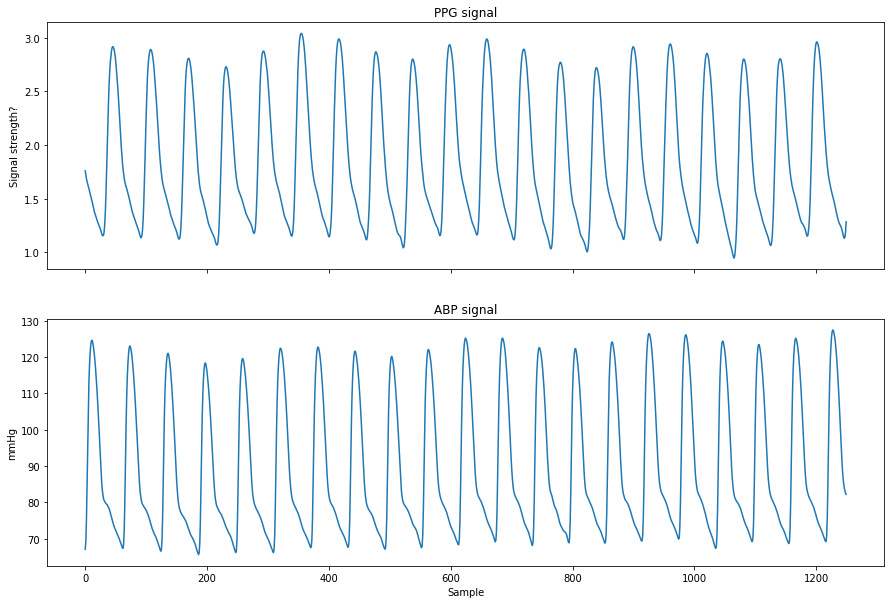

In [80]:
fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)

ax[0].set_title("PPG signal")
ax[0].set_ylabel("Signal strength?")
ax[0].plot(ppg[0])

ax[1].set_title("ABP signal")
ax[1].set_ylabel("mmHg")
ax[1].set_xlabel("Sample")
ax[1].plot(bp[0])

### Displaying SBP and DBP

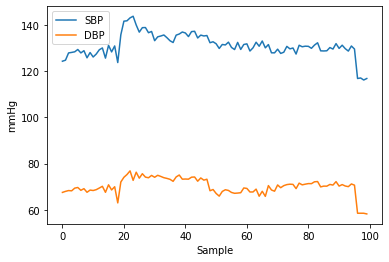

In [81]:
plt.plot(sbp[:100])
plt.plot(dbp[:100])
plt.ylabel("mmHg")
plt.xlabel("Sample")
plt.legend(["SBP", "DBP"])
plt.show()

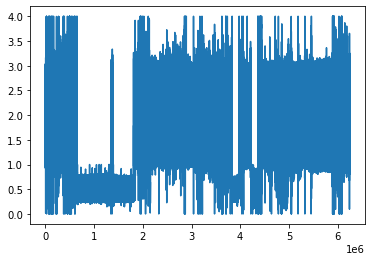

In [ ]:
bigger = np.concatenate(ppg[0:50000])
plt.plot(bigger)

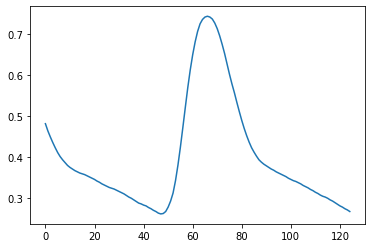

In [ ]:
plt.plot(ppg[9500])

### Baseline model without any features extracted

In [25]:
# since we want to predict both SBP and DBP we will pack them for each sample
target_bp = []
for i in range(len(ppg)):
    target_bp.append((sbp[i], dbp[i]))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(ppg, target_bp, test_size=0.3)

In [ ]:
len(x_train)

463534

In [ ]:
len(y_train)

463534

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mean_absolute_error(y_test, y_pred)

13.86339247983679

In [ ]:
y_pred[0]

array([132.84265271,  65.68463503])

In [ ]:
y_test[0]

(123.08702252492512, 54.50996711818112)

With our baseline Linear Regression of just 1 input variable - the ppg signal we are able to achieve MAE of 13.8 which for now does not say whether this model is good or bad, nevertheless, it gives us some point of reference for future optimizations.

In [ ]:
bp.shape

(662192, 125)

## Temporal Features Extraction

Since classic Machine Learning usually benefits from hand-picking some features from the input data, some features are extracted from the signal periods and assessed for validity. Features were chosen based on most popular ones in the recent scientific papers.
These include:
   - Cycle duration time
   - Time from cycle start to systolic peak
   - Time from systolic peak to cycle end
   - Time from systolic peak to dicrotic notch
   - Time from dicrotic notch to end
   - Ratio between systolic and diastolic amplitude

First we need both derivatives for some features:

In [26]:
ppg_i = []
ppg_ii = []

for i in range(len(ppg)):
    grad = np.gradient(ppg[i])
    ppg_i.append(grad)
    ppg_ii.append(np.gradient(grad))

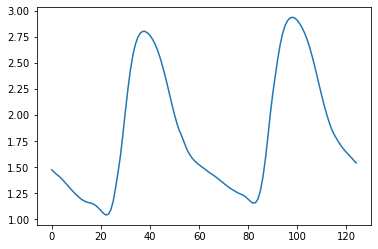

In [ ]:
plt.plot(ppg[4])

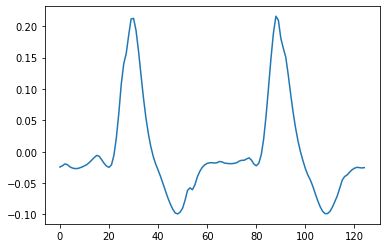

In [ ]:
plt.plot(ppg_i[4])

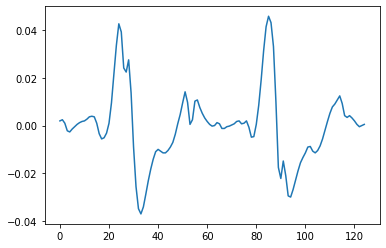

In [ ]:
plt.plot(ppg_ii[4])

Now the relevant features need to be extracted:

In [27]:
def time_cycle(inp, sys_1, sys_2, dia_1):
    # sometimes there may be no diastole to the left (no proper one) -> in cases which break the algorithm
    # (signal is not pure in the window), return -1 and then clean the signal
    THRESHOLD = 0.5 # safely basing on the data we can assume such minimal threshold for dia/sys difference
    dia_2 = np.argmin(inp[sys_1:sys_2]) + sys_1
    #print(dia_2 + sys_1)
    cycle_len = dia_2 - dia_1
    return cycle_len, dia_2

In [28]:
def dicr_notch(inp_ii, sys_1):
    peaks_raw, _ = find_peaks(inp_ii[sys_1:], height=0) # find first above 0 in the ppg'' after systole
    peaks_raw += sys_1
    if len(peaks_raw) < 1:
        return -1
    return peaks_raw[0]

In [29]:
def time_start_sys(sys_1, dia_1):
    return sys_1 - dia_1

def time_sys_end(sys_1, dia_2):
    return dia_2 - sys_1

def time_sys_dicr(sys_1, dicr):
    return dicr - sys_1

def time_dicr_end(dia_2, dicr):
    return dia_2 - dicr

def ratio_sys_dia(inp, sys_1, dia_1):
    return inp[sys_1] / inp[dia_1]

In [30]:
def extract_features(inp, inp_ii):
    # calculate the peaks -> systolic (maxima)
    peaks_raw, _ = find_peaks(inp)
    if len(peaks_raw) < 1: # hopeless if could not find any peaks
        return -1, -1, -1, -1, -1, -1
    sys_1 = peaks_raw[0]
    if len(peaks_raw) < 2:
        sys_2 = -1
    else:
        sys_2 = peaks_raw[1]
    
    # to find the beginning of the cycle (diastole), we need to go left of the first systole
    dia_1 = np.argmin(inp[:sys_1])
    
    cycle_len, dia_2 = time_cycle(inp, sys_1, sys_2, dia_1)
    #print(f"{sys_1} : {sys_2} : {dia_1} : {dia_2} : {cycle_len}")
    t_start_sys = time_start_sys(sys_1, dia_1)
    t_sys_end = time_sys_end(sys_1, dia_2)
    
    dicr = dicr_notch(inp_ii, sys_1) # if could not extract dicrotic -> abort, not worth it
    if dicr == -1:
        return -1, -1, -1, -1, -1, -1
    t_sys_dicr = time_sys_dicr(sys_1, dicr)
    t_dicr_end = time_dicr_end(dia_2, dicr)
    ratio = ratio_sys_dia(inp, sys_1, dia_1)

    cycle_len /= FS
    t_start_sys /= FS
    t_sys_end /= FS
    t_sys_dicr /= FS
    t_dicr_end /= FS
    return cycle_len, t_start_sys, t_sys_end, t_sys_dicr, t_dicr_end, ratio

In [31]:
cycle_len, t_start_sys, t_sys_end, t_sys_dicr, t_dicr_end, ratio = extract_features(ppg[0], ppg_ii[0])

In [32]:
cycle_len, t_start_sys, t_sys_end, t_sys_dicr, t_dicr_end, ratio 

(0.504, 0.128, 0.376, 0.128, 0.248, 2.5318066157760812)

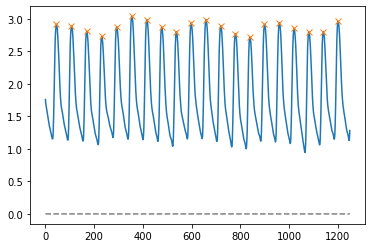

In [33]:
# easiest -> find peaks with scipy and then categorize them
peaks_raw, _ = find_peaks(ppg[0])
plt.plot(ppg[0])
plt.plot(peaks_raw, ppg[0][peaks_raw], "x")
plt.plot(np.zeros_like(ppg[0]), "--", color="gray")
plt.show()

In [34]:
# easiest -> find peaks with scipy and then categorize them
peaks_raw, _ = find_peaks(ppg_ii[16303][sys_1:], height=0)
peaks_raw += sys_1
plt.plot(ppg_ii[163030])
plt.plot(peaks_raw, ppg_ii[16303][peaks_raw], "x")
plt.plot(np.zeros_like(ppg_ii[16303]), "--", color="gray")
plt.show()

NameError: ignored

# TODO: increase the sample size (to all of the data)

With these features in place, we can extract now some spectral features.

## Spectral Features Extraction

//#TODO: consider longer periods for DL and shorter for ML (not lose features or get wrong ones)

Additionally, we can extract spectral features, which could help the models:
 - Three largest magnitudes (both values and frequencies)
 - Normalized energy
 - Entropy
 - Histogram - Binned distribution from 0 to 60 Hz (10 bins)
 - Skewness
 - Kurtosis

In [35]:
def freq_fftfreq(inp):
    freq = fft(inp)
    fftfreqs = fftfreq(FS, 1 / FS)[:FS//2]
    return freq, fftfreqs

In [36]:
def freq_magnitudes(freq, fftfreqs):
    yf = freq
    xf = fftfreqs
    #plt.plot(xf, np.abs(yf[:FS//2])) # do not normalize (not to loose float precision?)
    #plt.show()
    freq_mag = zip(xf[:FS//2], np.abs(yf[:FS//2]))
    sort = sorted(freq_mag, reverse=True, key=lambda pair: pair[1])
    
    # always ignore DC component
    freqs, mags = [x[0] for x in sort[1:4]], [x[1] for x in sort[1:4]]
    return freqs, mags

In [37]:
freq, fftfreqs = freq_fftfreq(ppg[0])
freq_magnitudes(freq, fftfreqs)

([21.0, 20.0, 41.0],
 [354.02084158627275, 259.57587902648845, 174.0035177580687])

In [38]:
def norm_energy(freq):
    fabs = np.abs(freq[:FS//2])
    energy = 0.
    for f in fabs:
        energy += f * f
    energy /= FS
    return energy

In [39]:
norm_energy(freq)

43829.34862321564

In [40]:
def fft_entropy(freq):
    # normalize the input
    freqs = freq / FS

    entr = 0.
    for f in freqs:
        entr += f * np.log(f)
    return -entr

In [41]:
fft_entropy(freq)

(-7.070671829512988-9.992007221626409e-16j)

In [42]:
np.histogram(np.abs(freq) / np.sum(freq), bins=np.arange(0, 125, 125//10))

(array([1250,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([  0,  12,  24,  36,  48,  60,  72,  84,  96, 108, 120]))

In [43]:
def extract_spectral_features(inp):
    freq, fftfreqs = freq_fftfreq(inp)
    freqs, mags = freq_magnitudes(freq, fftfreqs)
    energy = norm_energy(freq)
    entro = fft_entropy(freq).real
    bins, _ = np.histogram(np.abs(freq) / np.sum(freq), bins=np.arange(0, FS, FS//10))
    skewness = skew(freq).real
    kurt = kurtosis(freq).real
    
    return freqs[0], mags[0], freqs[1], mags[1], freqs[2], mags[2], energy, entro, bins, skewness, kurt

In [44]:
freq_1, mag_1, freq_2, mag_2, freq_3, mag_3, energy, entropy, bins, skewness, kurt = extract_spectral_features(ppg[0])
freq_1, mag_1, freq_2, mag_2, freq_3, mag_3, energy, entropy, bins, skewness, kurt

(21.0,
 354.02084158627275,
 20.0,
 259.57587902648845,
 41.0,
 174.0035177580687,
 43829.34862321564,
 -7.070671829512988,
 array([1250,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 32.89839794281231,
 1134.571379998692)

# Assemble dataframes and clean the data

In [45]:
def extract_features_long_seg(ppg, ppg_ii):
    cycle_lens, t_start_syss, t_sys_ends, t_sys_dicrs, t_dicr_ends, ratios = [], [], [], [], [], []
    for k in range(NUM_PERIODS):
      cycle_len, t_start_sys, t_sys_end, t_sys_dicr, t_dicr_end, ratio = extract_features(ppg[k * FS : (k + 1) * FS], ppg_ii[k * FS : (k + 1) * FS])
      if cycle_len == -1:
        continue
      cycle_lens.append(cycle_len)
      t_start_syss.append(t_start_sys)
      t_sys_ends.append(t_sys_end)
      t_sys_dicrs.append(t_sys_dicr)
      t_dicr_ends.append(t_dicr_end)
      ratios.append(ratio)

    return np.mean(cycle_lens), np.mean(t_start_syss), np.mean(t_sys_ends), np.mean(t_sys_dicrs), np.mean(t_dicr_ends), np.mean(ratios) 

In [46]:
rows = []

for i in range(len(ppg)):
    cycle_len, t_start_sys, t_sys_end, t_sys_dicr, t_dicr_end, ratio = extract_features_long_seg(ppg[i], ppg_ii[i])
    freq_1, mag_1, freq_2, mag_2, freq_3, mag_3, energy, entro, bins, skewness, kurt = extract_spectral_features(ppg[i])
    rows.append((cycle_len, t_start_sys, t_sys_end, t_sys_dicr, t_dicr_end, ratio,
                freq_1, mag_1, freq_2, mag_2, freq_3, mag_3, energy, entro, skewness, kurt, *bins))
    
rows = np.array(rows)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in cdouble_scalars
  import sys


In [61]:
# make a df from the data to clean it
bins = [f"bin_{i}" for i in range(10)]
ppgs = [f"ppg_{i}" for i in range(FS)]
col = ["cycle_len", "t_start_sys", "t_sys_end", "t_sys_dicr", "t_dicr_end", "ratio", 
       "freq_1", "mag_1", "freq_2", "mag_2", "freq_3", "mag_3", "energy", "entropy", "skewness", "kurtosis", *bins]
df = pd.DataFrame(rows, columns=col)
df.head()

,cycle_len,t_start_sys,t_sys_end,t_sys_dicr,t_dicr_end,ratio,freq_1,mag_1,freq_2,mag_2,freq_3,mag_3,energy,entropy,skewness,kurtosis,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9
0,0.4880,0.1248,0.3632,0.1104,0.2528,2.593674,21.0,354.020842,20.0,259.575879,41.0,174.003518,43829.348623,-7.070672,32.898398,1134.571380,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.4488,0.0944,0.3544,0.1072,0.2472,2.161049,21.0,346.265379,20.0,287.687770,41.0,206.545051,45633.816504,-37.359168,31.572125,1074.224769,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.4544,0.0936,0.3608,0.1024,0.2584,2.172335,21.0,419.506204,20.0,203.216216,41.0,165.781794,43908.685432,-33.888914,36.519122,1319.076605,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4936,0.1344,0.3592,0.1040,0.2552,3.270246,20.0,355.430816,21.0,283.509273,41.0,194.881672,44495.001618,22.974750,37.480233,1353.137826,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4280,0.1264,0.3016,0.0896,0.2120,2.443213,20.0,322.062191,21.0,211.012755,22.0,203.845301,46081.650764,42.094587,35.140830,1232.536849,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Because there is not much of the data, we can freely remove it without impacting the dataset too heavily.

In [62]:
idxs = df.loc[df['t_sys_end'] < 0.].index
inf_idxs = df.loc[df.values >= np.finfo(np.float64).max].index
indices = idxs.append(inf_idxs)
df = df.drop(indices)
df.head()

,cycle_len,t_start_sys,t_sys_end,t_sys_dicr,t_dicr_end,ratio,freq_1,mag_1,freq_2,mag_2,freq_3,mag_3,energy,entropy,skewness,kurtosis,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9
0,0.4880,0.1248,0.3632,0.1104,0.2528,2.593674,21.0,354.020842,20.0,259.575879,41.0,174.003518,43829.348623,-7.070672,32.898398,1134.571380,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.4488,0.0944,0.3544,0.1072,0.2472,2.161049,21.0,346.265379,20.0,287.687770,41.0,206.545051,45633.816504,-37.359168,31.572125,1074.224769,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.4544,0.0936,0.3608,0.1024,0.2584,2.172335,21.0,419.506204,20.0,203.216216,41.0,165.781794,43908.685432,-33.888914,36.519122,1319.076605,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4936,0.1344,0.3592,0.1040,0.2552,3.270246,20.0,355.430816,21.0,283.509273,41.0,194.881672,44495.001618,22.974750,37.480233,1353.137826,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4280,0.1264,0.3016,0.0896,0.2120,2.443213,20.0,322.062191,21.0,211.012755,22.0,203.845301,46081.650764,42.094587,35.140830,1232.536849,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
pd.options.display.max_rows = 1000
pd.isnull(df).sum() > 0

cycle_len      False
t_start_sys    False
t_sys_end      False
t_sys_dicr     False
t_dicr_end     False
ratio          False
freq_1         False
mag_1          False
freq_2         False
mag_2          False
freq_3         False
mag_3          False
energy         False
entropy         True
skewness       False
kurtosis       False
bin_0          False
bin_1          False
bin_2          False
bin_3          False
bin_4          False
bin_5          False
bin_6          False
bin_7          False
bin_8          False
bin_9          False
dtype: bool

In [63]:
df.fillna(0, inplace=True)

In [56]:
df.dtypes

cycle_len      float64
t_start_sys    float64
t_sys_end      float64
t_sys_dicr     float64
t_dicr_end     float64
ratio          float64
freq_1         float64
mag_1          float64
freq_2         float64
mag_2          float64
freq_3         float64
mag_3          float64
energy         float64
entropy        float64
skewness       float64
kurtosis       float64
bin_0          float64
bin_1          float64
bin_2          float64
bin_3          float64
bin_4          float64
bin_5          float64
bin_6          float64
bin_7          float64
bin_8          float64
bin_9          float64
dtype: object

In [64]:
# clean also the target variables
col = ["SBP" , "DBP"]
df_target = pd.DataFrame(target_bp, columns=col)
df_target = df_target.drop(indices)
df_target.head()

,SBP,DBP
0,124.337552,67.492783
1,124.786918,67.937265
2,127.932478,68.288942
3,128.152276,68.176601
4,128.416035,69.334206


In [51]:
df.describe()

,cycle_len,t_start_sys,t_sys_end,t_sys_dicr,t_dicr_end,ratio,freq_1,mag_1,freq_2,mag_2,freq_3,mag_3,energy,entropy,skewness,kurtosis,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9
count,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.000000,64456.0,64456.0,64456.0,64456.0,64456.0,64456.0,64456.0
mean,0.442144,0.127784,0.314360,0.093809,0.220551,2.049950,14.718056,342.624333,20.163569,186.224900,21.539624,133.617784,36308.785487,-5.543050,35.566565,1259.221380,1249.999969,0.000016,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.145370,0.042792,0.117196,0.020634,0.109738,4.465608,4.221277,121.592932,9.518615,68.868611,11.804871,55.556927,13447.113218,21.862551,3.219641,151.549479,0.005570,0.003939,0.003939,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.068000,0.011556,0.019200,0.017600,-0.043200,1.001015,1.000000,34.365509,1.000000,23.168951,1.000000,9.101054,1691.572260,-89.053560,26.378352,879.103277,1249.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.312000,0.096800,0.210400,0.080000,0.126400,1.629077,12.000000,288.347745,13.000000,153.297873,13.000000,97.183000,36032.668051,-20.539261,33.060948,1139.808714,1250.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.451556,0.122400,0.322400,0.092000,0.225600,1.927782,14.000000,360.518828,18.000000,191.269831,21.000000,138.414646,39596.804411,-5.392093,35.450767,1250.986639,1250.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.568000,0.153600,0.416000,0.105600,0.313600,2.261274,16.000000,430.118513,28.000000,232.090276,30.000000,173.345801,43575.105601,7.441500,37.954430,1370.335745,1250.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.942400,0.497778,0.754400,0.213600,0.654400,410.781156,46.000000,593.146635,56.000000,425.829332,60.000000,345.323190,65454.456268,85.182220,45.265006,1696.106193,1250.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Briefly exploring the data, it can be seen there are some outliers which should be eliminated in order to make the models' predictions better.

In [65]:
# only some columns are striking, remove only rows where outliers are present in these columns
sus = ["ratio", "mag_1", "mag_2", "mag_3", "energy", "entropy", "skewness", "kurtosis"]
to_remove = set()

indices = set()
for x in sus:
  q25, q75 = np.percentile(df.loc[:,x], [25, 75])
  intra = q75 - q25

  max = q75 + intra * 1.5
  min = q25 - intra * 1.5

  idxs_1 = df.loc[df[x] < min, x].index
  idxs_2 = df.loc[df[x] > max, x].index
  to_remove = to_remove.union(idxs_1).union(idxs_2)

In [66]:
len(to_remove)

9559

In [67]:
df.drop(to_remove, inplace=True)
df_target.drop(to_remove, inplace=True)

The data can be saved for later, so that we do not have to do the manual cleaning each time we want to access it. The form of storage is .csv files of fixed number of rows.

In [69]:
tosave = df.join(df_target)
tosave.to_csv('part_1_long.csv')

,cycle_len,t_start_sys,t_sys_end,t_sys_dicr,t_dicr_end,ratio,freq_1,mag_1,freq_2,mag_2,freq_3,mag_3,energy,entropy,skewness,kurtosis,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,SBP,DBP
0,0.4880,0.1248,0.3632,0.1104,0.2528,2.593674,21.0,354.020842,20.0,259.575879,41.0,174.003518,43829.348623,-7.070672,32.898398,1134.571380,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.337552,67.492783
1,0.4488,0.0944,0.3544,0.1072,0.2472,2.161049,21.0,346.265379,20.0,287.687770,41.0,206.545051,45633.816504,-37.359168,31.572125,1074.224769,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.786918,67.937265
2,0.4544,0.0936,0.3608,0.1024,0.2584,2.172335,21.0,419.506204,20.0,203.216216,41.0,165.781794,43908.685432,-33.888914,36.519122,1319.076605,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.932478,68.288942
4,0.4280,0.1264,0.3016,0.0896,0.2120,2.443213,20.0,322.062191,21.0,211.012755,22.0,203.845301,46081.650764,42.094587,35.140830,1232.536849,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.416035,69.334206
5,0.4712,0.1024,0.3688,0.1088,0.2600,2.235701,20.0,422.614817,21.0,190.952115,41.0,164.318647,44130.593742,-19.474841,39.744026,1445.682314,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.417339,69.622386


If the data is already available, load it.

In [74]:
df = pd.read_csv('part_1_long.csv', index_col=0)
df_target = pd.DataFrame(df, columns=["SBP", "DBP"])
df.drop(["SBP", "DBP"], axis=1, inplace=True)

,cycle_len,t_start_sys,t_sys_end,t_sys_dicr,t_dicr_end,ratio,freq_1,mag_1,freq_2,mag_2,freq_3,mag_3,energy,entropy,skewness,kurtosis,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9
0,0.4880,0.1248,0.3632,0.1104,0.2528,2.593674,21.0,354.020842,20.0,259.575879,41.0,174.003518,43829.348623,-7.070672,32.898398,1134.571380,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.4488,0.0944,0.3544,0.1072,0.2472,2.161049,21.0,346.265379,20.0,287.687770,41.0,206.545051,45633.816504,-37.359168,31.572125,1074.224769,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.4544,0.0936,0.3608,0.1024,0.2584,2.172335,21.0,419.506204,20.0,203.216216,41.0,165.781794,43908.685432,-33.888914,36.519122,1319.076605,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4280,0.1264,0.3016,0.0896,0.2120,2.443213,20.0,322.062191,21.0,211.012755,22.0,203.845301,46081.650764,42.094587,35.140830,1232.536849,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.4712,0.1024,0.3688,0.1088,0.2600,2.235701,20.0,422.614817,21.0,190.952115,41.0,164.318647,44130.593742,-19.474841,39.744026,1445.682314,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

In order to be better informed about the nature and the relations of the features we extracted, we will plot histograms of several of the most prominent, and a correlation matrix.

In [14]:
df.describe()

,cycle_len,t_start_sys,t_sys_end,t_sys_dicr,t_dicr_end,ratio,freq_1,mag_1,freq_2,mag_2,freq_3,mag_3,energy,entropy,skewness,kurtosis,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9
count,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.000000,54897.0,54897.0,54897.0,54897.0,54897.0,54897.0,54897.0,54897.0
mean,0.438804,0.125859,0.312945,0.094671,0.218274,1.916834,14.482413,378.557518,19.872252,205.107387,21.431135,147.258319,40783.295061,-7.092605,35.546736,1258.371936,1249.999982,0.000018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.143371,0.042210,0.115670,0.021226,0.106670,0.406563,3.872455,80.866772,9.149449,48.849114,11.621215,44.268801,4651.391923,22.136953,3.281303,154.280273,0.004268,0.004268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.068000,0.012800,0.019200,0.024800,-0.043200,1.001015,1.000000,135.011972,1.000000,52.564066,1.000000,24.609408,26277.797734,-62.496988,26.378352,879.103277,1249.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.313600,0.095200,0.212800,0.080800,0.128800,1.602858,12.000000,319.319554,13.000000,168.058001,13.000000,115.104126,37489.538750,-22.390066,32.966496,1135.186238,1250.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.443200,0.120000,0.317600,0.092800,0.220800,1.898774,14.000000,376.955084,18.000000,200.006493,21.000000,146.345625,40354.923282,-9.149858,35.431289,1249.999928,1250.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.561600,0.151200,0.412000,0.106400,0.305600,2.233567,16.000000,440.344177,26.000000,237.967603,30.000000,178.301362,43973.576637,7.125447,38.011162,1373.305002,1250.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.942400,0.497778,0.754400,0.213600,0.654400,3.205748,42.000000,593.146635,56.000000,349.971067,60.000000,286.411120,54881.288322,49.397166,45.265006,1690.951871,1250.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After removing the outliers, both the standard deviation and the extreme values have been much reduced.

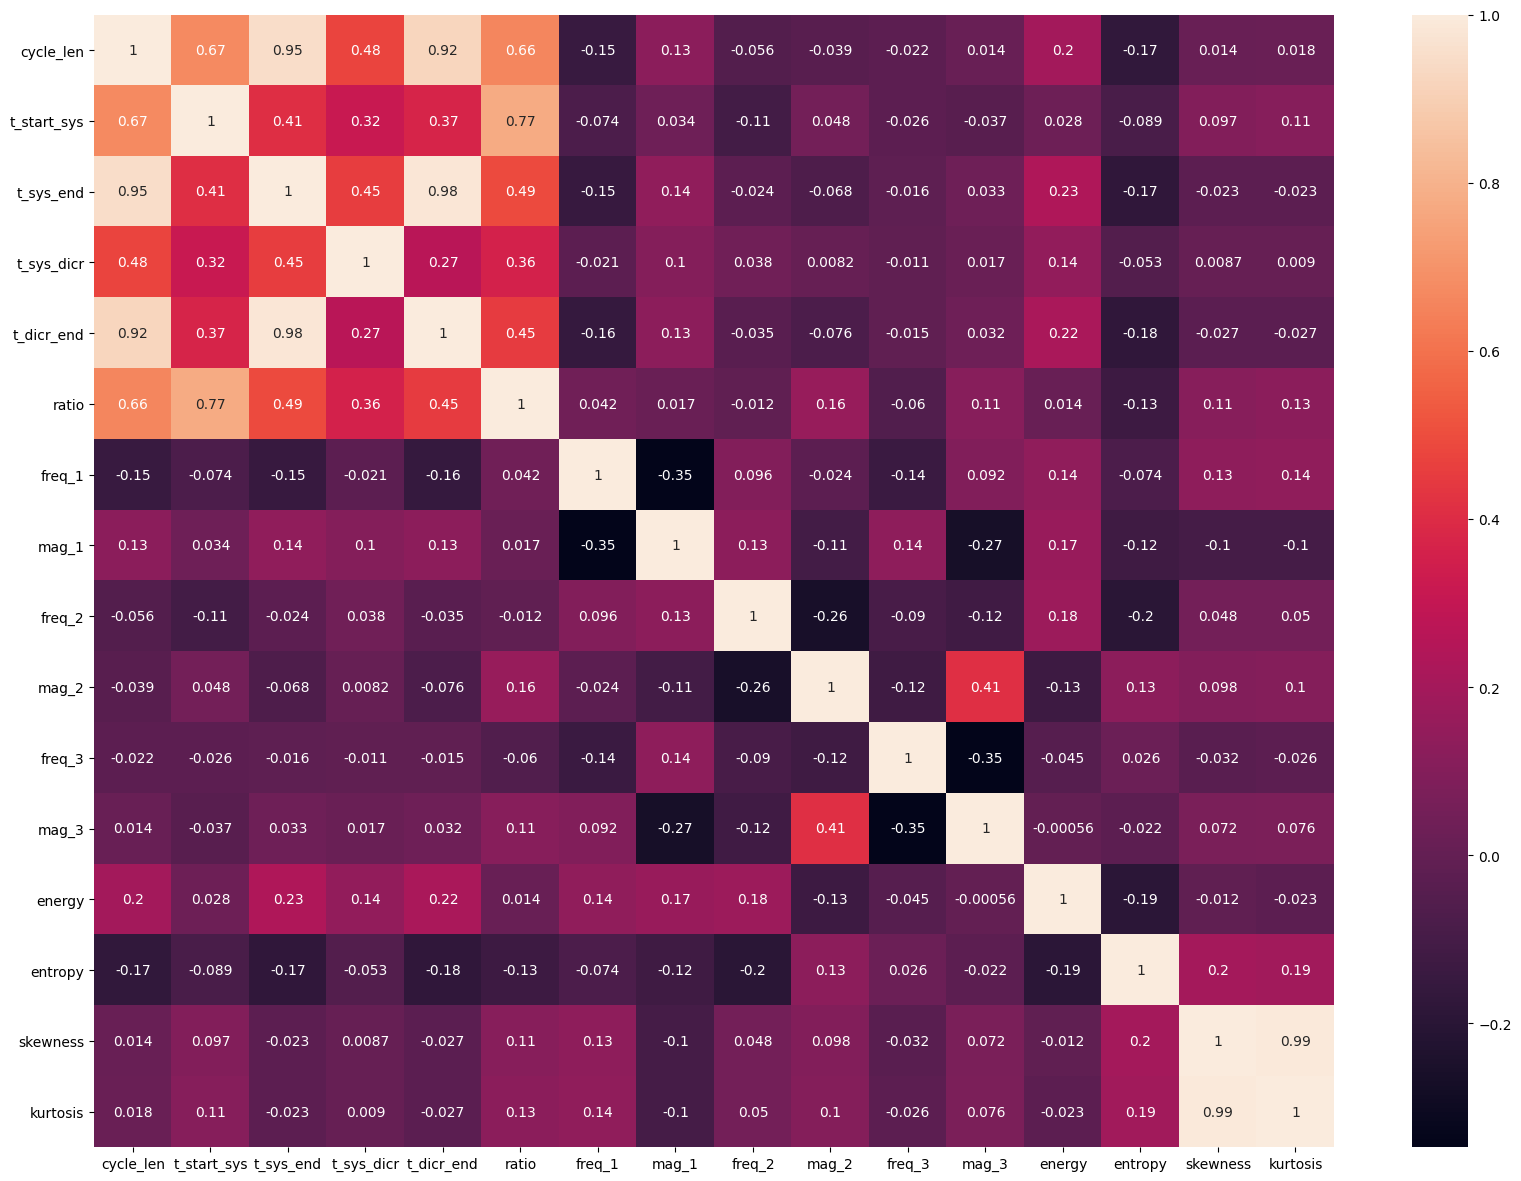

In [ ]:
# correlation plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (20,15)
scatter_var = ["cycle_len", "t_start_sys", "t_sys_end", "t_sys_dicr", "t_dicr_end", "ratio", 
               "freq_1", "mag_1", "freq_2", "mag_2", "freq_3", "mag_3", "energy", "entropy", "skewness", "kurtosis"]
correlation_matrix = df[scatter_var].corr()
sns.heatmap(correlation_matrix, annot=True)

In [ ]:
# scatterplot and distribution together
sns.pairplot(df[scatter_var])

Output hidden; open in https://colab.research.google.com to view.

# Machine Learning

Having the data prepared, we can now proceed with the training of various models to assess which one is the best. The most promising models in the literature are a Random Forest and Linear Regression so we are using them here as well.

The data is further split using K-Fold cross-validation, in order to train the model for a given number of epochs. Then it is finally used to predict on the intact test set.

In [75]:
folds = KFold(n_splits=10, shuffle=False) # shuffle or not?

In [76]:
# resplit the data after processing
x_train, x_test, y_train, y_test = train_test_split(df, df_target, test_size=0.3)

## Linear Regression

In [ ]:
# TODO: remove small testing -> it looks like there is some problem with the folds? some fucked up stuff 

In [ ]:
small_df = df.iloc[:10000]
small_df_target = df.iloc[:10000]

In [ ]:
linear = LinearRegression()
forest = RandomForestRegressor(n_estimators=10)
x_train, x_test, y_train, y_test = train_test_split(small_df, small_df_target, test_size=0.3)
linear.fit(x_train, y_train)
forest.fit(x_train, y_train)
predictions = linear.predict(x_test)
predictions_forest = forest.predict(x_test)
error_linear = mean_absolute_error(predictions, y_test)
error_forest = mean_absolute_error(predictions_forest, y_test)
error_linear, error_forest

(3.5495305560957576e-14, 0.12759713033902265)

In [115]:
linear = LinearRegression()
errors_sbp = []
errors_dbp = []

for i, (train_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    train_data, train_target = x_train.iloc[train_idx], y_train.iloc[train_idx]
    val_data, val_target = x_train.iloc[val_idx], y_train.iloc[val_idx]
    
    linear.fit(train_data, train_target) 
    predictions = linear.predict(val_data)
    error_sbp = mean_absolute_error(predictions[:,0], val_target["SBP"].values)
    error_dbp = mean_absolute_error(predictions[:,1], val_target["DBP"].values)
    #print(predictions)
    #print(val_target)
    print(f"Train fold {i} MAE SBP: {error_sbp} MAE DBP: {error_dbp}")
    errors_sbp.append(error_sbp)
    errors_dbp.append(error_dbp)
    
print(f"Average MAE SBP: {np.mean(errors_sbp)} MAE DBP: {np.mean(errors_dbp)}")

Train fold 0 MAE SBP: 17.11359429923384 MAE DBP: 8.138104266882898
Train fold 1 MAE SBP: 16.40959105646823 MAE DBP: 7.838352304542755
Train fold 2 MAE SBP: 16.591055647886176 MAE DBP: 8.190250071733384
Train fold 3 MAE SBP: 16.83635995536116 MAE DBP: 8.353748890046791
Train fold 4 MAE SBP: 16.688816970545314 MAE DBP: 8.121563010201292
Train fold 5 MAE SBP: 16.595427347371835 MAE DBP: 8.223440792113202
Train fold 6 MAE SBP: 16.77903773964595 MAE DBP: 8.35004965410661
Train fold 7 MAE SBP: 16.752867156016077 MAE DBP: 8.31914844512881
Train fold 8 MAE SBP: 16.676656196301497 MAE DBP: 8.057509965199397
Train fold 9 MAE SBP: 16.772748368043576 MAE DBP: 8.334123119237233
Average MAE SBP: 16.72161547368737 MAE DBP: 8.192629051919237


## Random Forest

In [ ]:
forest = RandomForestRegressor(n_estimators=100)
errors_sbp = []
errors_dbp = []

for i, (train_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    train_data, train_target = x_train.iloc[train_idx], y_train.iloc[train_idx]
    val_data, val_target = x_train.iloc[val_idx], y_train.iloc[val_idx]
    
    forest.fit(train_data, train_target) 
    predictions = forest.predict(val_data)
    error_sbp = mean_absolute_error(predictions[:,0], val_target["SBP"].values)
    error_dbp = mean_absolute_error(predictions[:,1], val_target["DBP"].values)
    print(f"Train fold {i} MAE SBP: {error_sbp} MAE DBP: {error_dbp}")
    errors_sbp.append(error_sbp)
    errors_dbp.append(error_dbp)
    
print(f"Average MAE SBP: {np.mean(errors_sbp)} MAE DBP: {np.mean(errors_dbp)}")

Train fold 0 MAE SBP: 12.520103962604507 MAE DBP: 6.578353167018368
Train fold 1 MAE SBP: 12.822918350568413 MAE DBP: 6.7401553994530525
Train fold 2 MAE SBP: 12.698623109274724 MAE DBP: 6.691901388432857
Train fold 3 MAE SBP: 12.82828354647025 MAE DBP: 6.698306146744449
Train fold 4 MAE SBP: 12.874089062348686 MAE DBP: 6.892814493409991
Train fold 5 MAE SBP: 12.939333319187142 MAE DBP: 6.723529865709227
Train fold 6 MAE SBP: 12.856279463461517 MAE DBP: 6.64219727292031
Train fold 7 MAE SBP: 12.700893023580834 MAE DBP: 6.554417836282708


We can show the whole tree to get an overview of splits.

In [ ]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(forest.estimators_[0], feature_names=df.columns, filled=True)

We can also visualize a single tree from the random forest to inspect its properties and the criteria for splitting.

In [ ]:
# visualize and test different hyperparameters

In [ ]:
# TODO: after consultations
Longer segments?
Remove signal from the training features
MAE should be for both of them
Presentation:
Different combination of features, models fed into the models, tweaking hyperparameters

# Deep Learning

Now we can try to develop a deep learning model to compare with our machine learning counterparts. Because this task is a regression task and the PPG signal is prone to variations, the neural network used for this task is a recurrent neural network (RNN), which is known for compensating the accuracy loss happening over time by residual connections between layers.

In [ ]:
# Read up on the ResNets more and implement first a simpler one and test

# Not needed for the course

# Results

# References

- Slapničar G, Mlakar N, Luštrek M. _Blood Pressure Estimation from Photoplethysmogram Using a Spectro-Temporal Deep Neural Network._ Sensors (Basel). 2019;19(15):3420. Published 2019 Aug 4. doi:10.3390/s19153420
- Serj Haddad, Assim Boukhayma, and Antonino Caizzone -  _Continuous PPG-Based Blood Pressure MonitoringUsing Multi-Linear Regression_
- M. Kachuee, M. M. Kiani, H. Mohammadzade, M. Shabany, _Cuff-Less High-Accuracy Calibration-Free Blood Pressure Estimation Using Pulse Transit Time_, IEEE International Symposium on Circuits and Systems (ISCAS'15), 2015
- Khalid SG, Zhang J, Chen F, Zheng D. _Blood Pressure Estimation Using Photoplethysmography Only: Comparison between Different Machine Learning Approaches._ J Healthc Eng. 2018;2018:1548647. Published 2018 Oct 23. doi:10.1155/2018/1548647